# Pulsars, a marvel of the Universe

# Introduction

A **pulsar** is a highly magnetized, rotating neutron star that emits beams of electromagnetic radiation from its magnetic poles. Neutron stars are the incredibly dense cores of massive stars that have gone supernova, and they are composed mostly of neutrons.

As the pulsar rotates, its magnetic poles emit powerful beams of radiation that sweep across space like a lighthouse beam. If the Earth happens to be in the path of these beams, we can detect them as regular pulses of radiation that arrive at regular intervals, hence the name "pulsar." However, these signals can often be confused with radio frequency interference (RFI) or noise, which can make it difficult to identify true pulsar signals. The purpose of this project is to develop a data science model that can differentiate between pulsar signals and RFI using statistical features.

![pulsar gif](https://www.nasa.gov/sites/default/files/styles/full_width/public/thumbnails/image/pulsar-3.gif?itok=XPigpPY6)

![pulsar img](https://static.scientificamerican.com/sciam/cache/file/4A0E579E-0374-4971-8D43D374E1718ED7_source.jpg?w=590&h=800&7A631D33-D240-41EA-ABCA2B0D086E25ED)
> **How to determine if a signal is coming from a RFI or a pulsar?**

*Candidate* is the term that we'll use to refer to each detection. These are detected as periodic signals, which are represented by two curves: the **integrated profile** and the **DM-SNR curve**. The integrated profile is obtained by averaging the pulse signals emitted by the pulsar over a long observation period *(Lorimer and Kramer, 2005)*. Since the pulse profile of each pulsar is unique, the integrated profile represents the average of all the pulses emitted by the pulsar over a period of time. This allows astronomers to study the properties of pulsars, such as their rotation period, magnetic field strength, and emission properties.

However, the pulse signals detected by radio telescopes are affected by interstellar dispersion, where each pulse arrives at different times across different frequencies due to the scattering of radio waves by interstellar plasma. This dispersion can introduce uncertainty into the pulsar signal detection process. To account for this, a dispersion-measure-signal-to-noise **(DM-SNR) curve** is used *(Lyon, 2016)*. The **DM-SNR curve** represents the relationship between the dispersion measure (DM) and **signal-to-noise ratio (SNR)** of the detected pulse signals. The SNR is a measure of the strength of the pulsar signal relative to the background noise, and the DM is a measure of the amount of interstellar dispersion.

To further analyze and classify pulsar signals, each curve (the integrated profile and **DM-SNR curve**) is represented by four statistical variables: *mean, standard deviation, kurtosis, and skewness*. The mean is the average value of the curve, the standard deviation is the measure of the spread of the curve, the kurtosis is the measure of the peakedness of the curve, and the skewness is the measure of the symmetry of the curve. These statistical features can provide important information about the shape and distribution of the curves, which can be used to differentiate between pulsar signals and RFI.

In [1]:
#installing additional packages

install.packages('themis')
install.packages('caret')

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [2]:
#loading all the required libraries

library(tidyverse)
library(tidymodels)
library(repr)
library(httr)
library(readxl)
library(ggplot2)
library(gridExtra)
library(themis)
library(caret)
library(GGally)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# Methods and Results

### Loading the dataset into R

In [3]:
#downloading dataset from the url
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
GET(url, write_disk(pul <- tempfile(fileext = ".zip")))

#unzipping and loading the csv file in R
pulsar_data <- read_csv(unz(pul, "HTRU_2.csv"), col_names = FALSE)

#giving column names to the dataset
colnames(pulsar_data) <- c('mean_ip', 'std_ip', 'ekurtosis_ip', 'skew_ip', 'mean_dmsnr', 'std_dmsnr', 'ekurtosis_dmsnr', 'skew_dmsnr', 'class')

#mutating the class variable as a factor
pulsar_data <- mutate(pulsar_data, class = as.factor(class))
head(pulsar_data, 10)

Response [https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip]
  Date: 2023-04-13 09:16
  Status: 200
  Content-Type: application/x-httpd-php
  Size: 1.56 MB
<ON DISK>  /tmp/RtmpsTHZlx/file310b1c76c698.zipNULL

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


mean_ip,std_ip,ekurtosis_ip,skew_ip,mean_dmsnr,std_dmsnr,ekurtosis_dmsnr,skew_dmsnr,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.15832276,0.3895404,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.45268802,0.1703474,2.3319398,14.486853,9.001004,107.97251,0


_Table 1: The original dataset loaded into R_

The dataset we are using for this project is already in a tidy format.

## Splitting and Scaling the dataset

We wanted to ensure that our model accurately evaluated its performance, so we decided to split our data into training and testing sets. We chose a split of 78% for training and 22% for testing. By doing this, we were able to assess the model's accuracy on the testing set and obtain a reliable estimate of how well it would perform on new, unseen data. The 78/22 split is a widely used ratio that provides a good balance between having enough data for training and having sufficient data for testing.

In [6]:
#splitting the data for 78% training & 22% testing
#17,898 total samples;
#1,639 positive samples;
#16,259 negative samples;
set.seed(3400)

recipe_upsample <- recipe(class ~ mean_ip + std_ip + ekurtosis_ip + skew_ip, data = pulsar_data) |>
                   step_upsample(class, over_ratio = 1, skip = FALSE)

pulsar_upscaled <- recipe_upsample |>
                   prep() |>
                   bake(pulsar_data)

group_by(pulsar_upscaled, class) |>
summarize(n = n())

pulsar_split <- initial_split(pulsar_upscaled, prop = 0.78, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

glimpse(pulsar_train)
glimpse(pulsar_test)

class,n
<fct>,<int>
0,16259
1,16259


Rows: 25,364
Columns: 5
$ mean_ip      <dbl> 140.56250, 102.50781, 103.01562, 88.72656, 93.57031, 119.…
$ std_ip       <dbl> 55.68378, 58.88243, 39.34165, 40.67223, 46.69811, 48.7650…
$ ekurtosis_ip <dbl> -0.234571412, 0.465318154, 0.323328365, 0.600866079, 0.53…
$ skew_ip      <dbl> -0.69964840, -0.51508791, 1.05116443, 1.12349169, 0.41672…
$ class        <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
Rows: 7,154
Columns: 5
$ mean_ip      <dbl> 136.75000, 130.38281, 107.25781, 142.07812, 109.64062, 10…
$ std_ip       <dbl> 57.17845, 39.84406, 39.49649, 45.28807, 49.01765, 51.8903…
$ ekurtosis_ip <dbl> -0.06841464, -0.15832276, 0.46588196, -0.32032843, 0.1376…
$ skew_ip      <dbl> -0.636238369, 0.389540448, 1.162877124, 0.283952506, -0.2…
$ class        <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …


_Table 2: Split Data_

## Preliminary Summarization and Visualization:

When building a model to predict pulsars, it is important to understand the distribution of the relevant variables. We wanted to get a rough idea of the respective counts for relevant variables, so we decided to create histograms to visualize their distributions. To focus on our analysis, we chose to use only the integrated profile parameters because they mostly reflect the intensity of the wave and its phase, which are highly associated with making accurate predictions.

We plotted the histograms for the integrated profile parameters and studied them carefully as figure 3 and figure 5 showed us that they best reflected the characteristics of pulsars and the level of accuracy remained high even after upsampling the data. This indicates that the integrated profile parameters are highly relevant to the task of predicting pulsars.

Although DM-SNR parameters also reflect the characteristics of pulsars, we decided not to include them in our analysis as we were concerned that including too many predictor variables could introduce randomness into the distance calculations, leading to inaccurate predictions, therefore, we opted to include only the integrated profile parameters to minimize the randomness and obtain more reliable results.

In [10]:
pulsar_positive <- pulsar_train |>
                   group_by(class) |>
                   summarize(n = n())
pulsar_positive

pulsar_proportions <- pulsar_train |>
                      group_by(class) |>
                      summarize(n = n()) |>
                      mutate(percent = 100 * n / nrow(pulsar_train))
pulsar_proportions

mean_pulsar_train <- pulsar_train |>
                     group_by(class) |> 
                     summarize(max_mean_ip = max(mean_ip, na.rm = TRUE),
                               max_std_ip = max(std_ip, na.rm = TRUE),
                               max_ekurtosis_ip = max(ekurtosis_ip, na.rm = TRUE),
                               max_skew_ip = max(skew_ip, na.rm = TRUE),
                               min_mean_ip = min(mean_ip, na.rm = TRUE),
                               min_std_ip = min(std_ip, na.rm = TRUE),
                               min_ekurtosis_ip = min(ekurtosis_ip, na.rm = TRUE),
                               min_skew_ip = min(skew_ip, na.rm = TRUE)) |>
                               pivot_longer(cols = -class,
                                            names_to = "max_min_variables",
                                            values_to = "Value")
glimpse(mean_pulsar_train)
mean_pulsar_train

class,n
<fct>,<int>
0,12682
1,12682


class,n,percent
<fct>,<int>,<dbl>
0,12682,50
1,12682,50


Rows: 16
Columns: 3
$ class             <fct> 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1
$ max_min_variables <chr> "max_mean_ip", "max_std_ip", "max_ekurtosis_ip", "ma…
$ Value             <dbl> 192.61718750, 91.80862790, 4.78578590, 24.87242875, …


class,max_min_variables,Value
<fct>,<chr>,<dbl>
0,max_mean_ip,192.61718750
0,max_std_ip,91.80862790
0,max_ekurtosis_ip,4.78578590
0,max_skew_ip,24.87242875
0,min_mean_ip,27.60156250
0,min_std_ip,29.17210096
0,min_ekurtosis_ip,-1.87601118
0,min_skew_ip,-1.79188598
1,max_mean_ip,139.25781250


_Table 3: Mean of Training Data_

#### Visualizing the selected variables:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



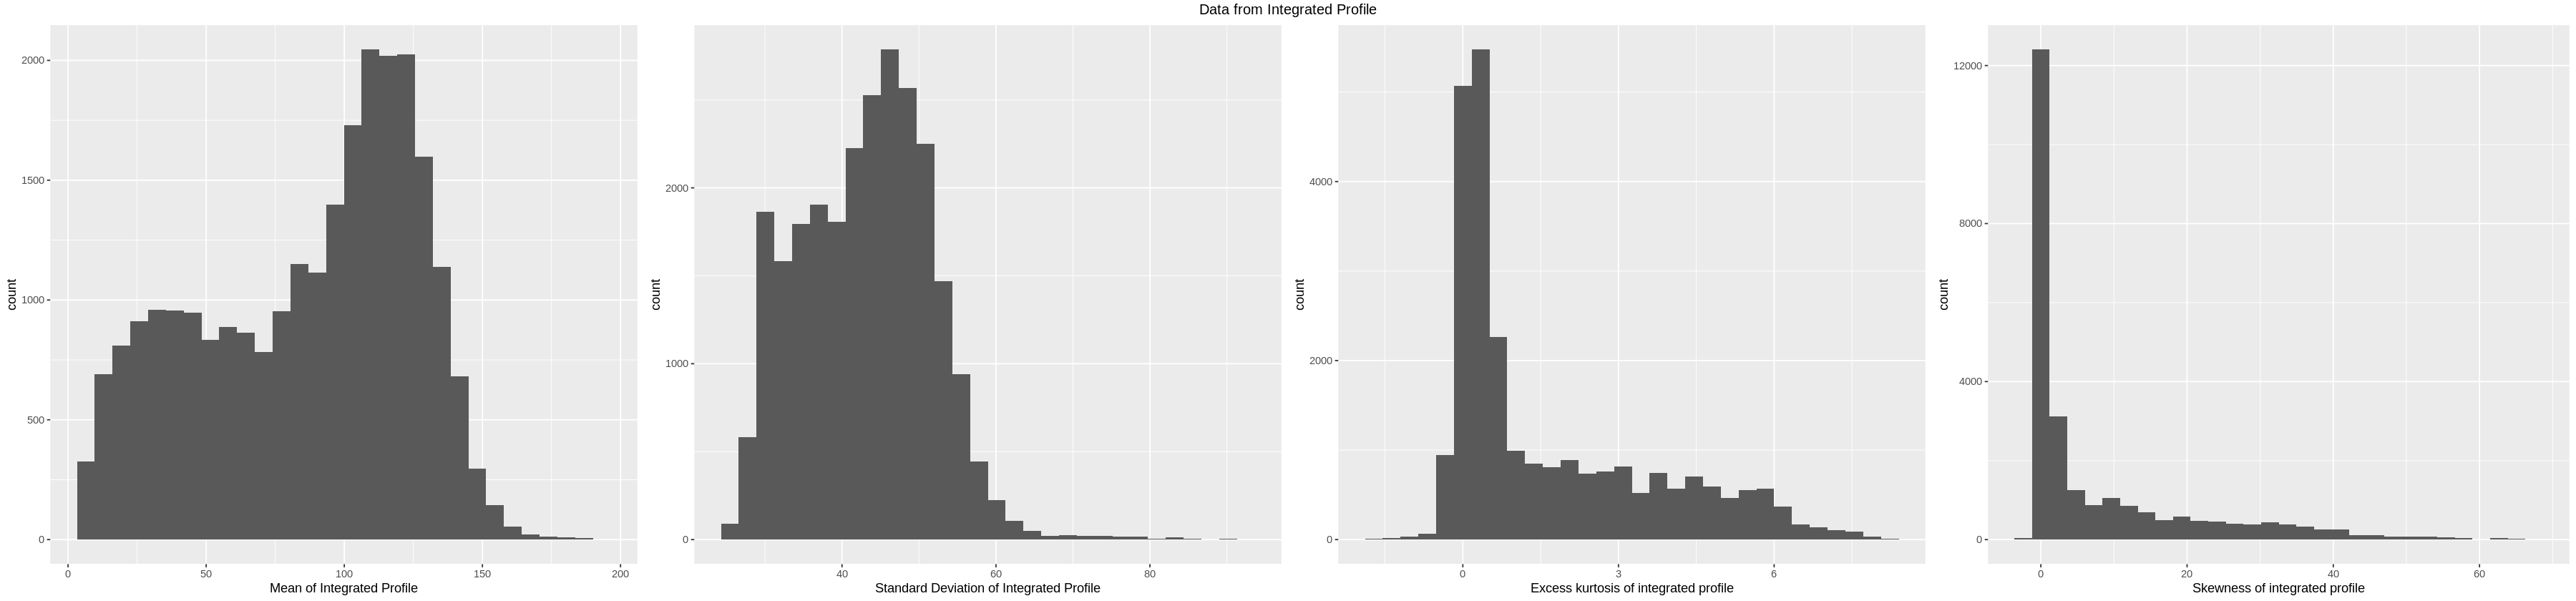

In [15]:
options(repr.plot.width=30, repr.plot.height=7)

hist_mean_ip <- ggplot(pulsar_train, aes(x = mean_ip)) +
                geom_histogram() + 
                labs(x = "Mean of Integrated Profile")

hist_std_ip <- ggplot(pulsar_train, aes(x = std_ip)) +
               geom_histogram() + 
               labs(x = "Standard Deviation of Integrated Profile")

hist_ekurtosis_ip <- ggplot(pulsar_train, aes(x = ekurtosis_ip)) +
                     geom_histogram() + 
                     labs(x = "Excess kurtosis of integrated profile")

hist_skew_ip <- ggplot(pulsar_train, aes(x = skew_ip)) +
                geom_histogram() + 
                labs(x = "Skewness of integrated profile")

grid.arrange(hist_mean_ip, hist_std_ip, hist_ekurtosis_ip, hist_skew_ip, nrow = 1, top = "Data from Integrated Profile")   

> **Figure 2:** *Visualization is a useful technique to understand the distribution of counts for each variable related to the integrated profile. The mean integrated profile has a central mean value around 100, while the standard deviation integrated profile has a mean of 50 and a range from approximately 10 to just below 100. The integrated profile kurtosis has a mean value of about 0, but its distribution is skewed to the right, with a range of values between -2 to nearly 9. The integrated profile skewness has a right-skewed distribution with a mean value just above 0, and a range of values between -2 to just below 9. By visualizing the distribution of these variables in relation to the integrated profile, we can gain insights into the characteristics of pulsars and create more accurate models for predicting pulsars.*

In [29]:
total <- pulsar_train |>
         mutate(type = "training")
totall <- pulsar_test |>
          mutate(type = "predictor")
combined <- rbind(total, totall)
combined

mean_ip,std_ip,ekurtosis_ip,skew_ip,class,type
<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
140.56250,55.68378,-0.234571412,-0.69964840,0,training
102.50781,58.88243,0.465318154,-0.51508791,0,training
103.01562,39.34165,0.323328365,1.05116443,0,training
88.72656,40.67223,0.600866079,1.12349169,0,training
93.57031,46.69811,0.531904850,0.41672112,0,training
119.48438,48.76506,0.031460220,-0.11216757,0,training
107.25000,52.62708,0.452688025,0.17034738,0,training
133.25781,44.05824,-0.081059862,0.11536151,0,training
134.96094,49.55433,-0.135303833,-0.08046960,0,training


_Table 4: Combined result of training and testing data_

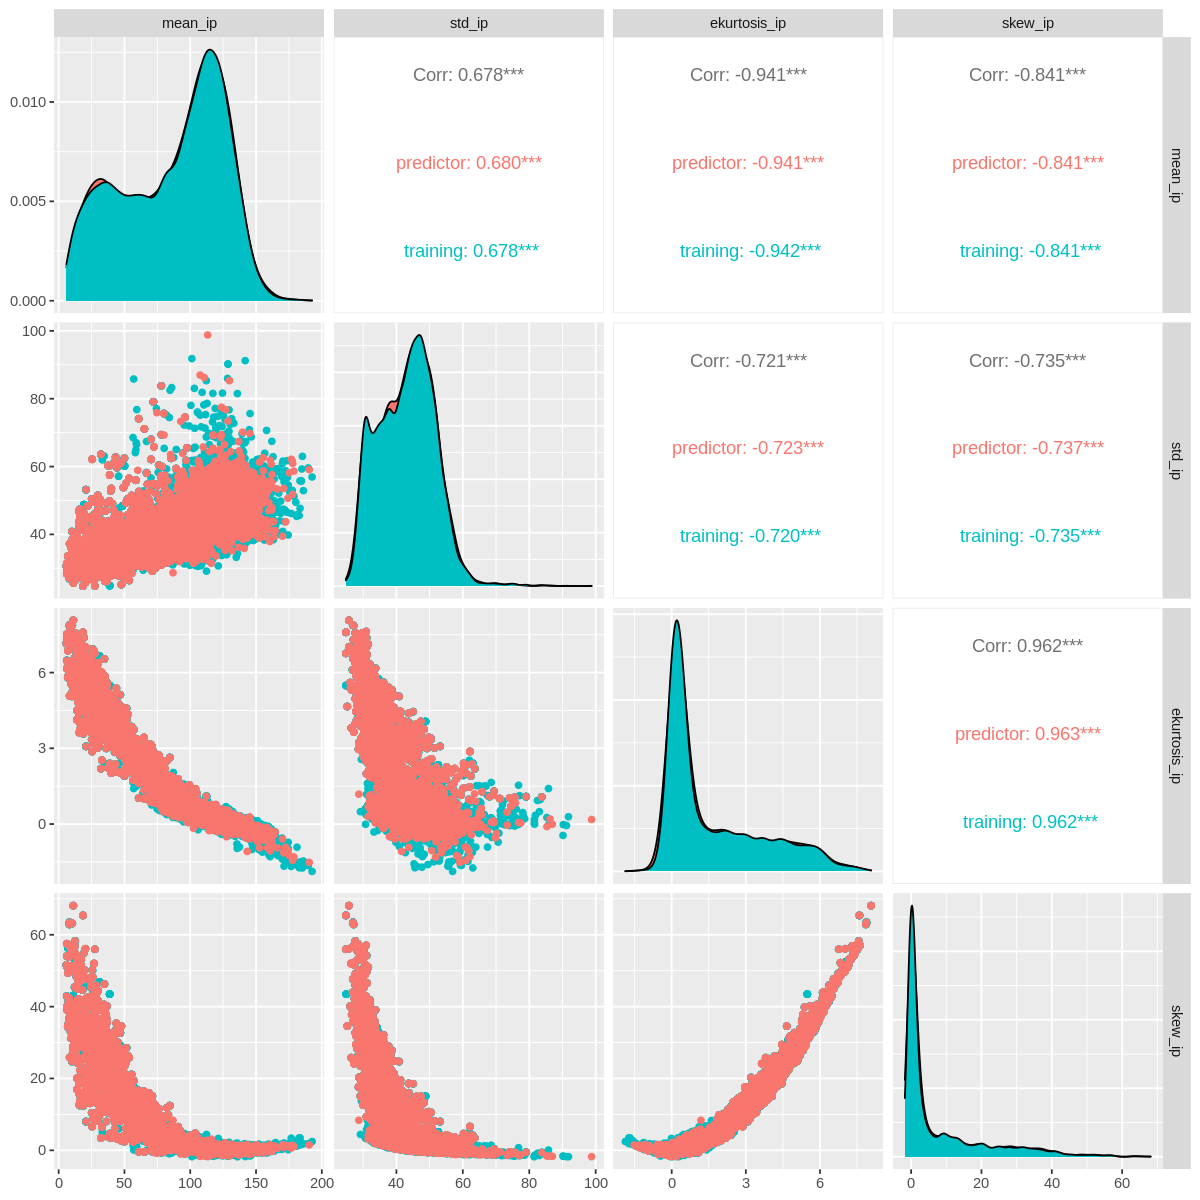

In [30]:
ggpairs(combined, aes(color = type), columns = 1:4)

> **Figure 3:** *The figure demonstrates the relationship between the variables mean integrated profile, standard deviation integrated profile, kurtosis integrated profile, and skewness integrated profile. A strong positive correlation was observed between mean integrated profile and standard deviation integrated profile, and the predictor and training variables overlapped. On the other hand, mean integrated profile versus standard deviation integrated profile exhibited a negative correlation and a strong negative correlation between the two variables. The visualization also indicated a strong negative correlation between mean integrated profile and kurtosis integrated profile, and the predictor and training sets overlapped. Similarly, a strong negative correlation was observed between standard deviation integrated profile and kurtosis integrated profile, and the predictor and training sets overlapped. Lastly, a strong negative correlation and overlap between the predictor and training sets were observed when comparing mean integrated profile and skewness integrated profile.*

## Classifier Model:

### Building and Training

We built a classifier for identifying pulsar stars using the integrated profile parameters. The classifier is built using the `nearest_neighbor()` function and performing the cross-validation technique by using the `tune()` function to determine the optimal K value for accurate analysis. The variables are scaled to ensure that none of the predictors have even a slight significant influence on the distance calculations than others. We performed the upsampling manually, prior to splitting as the step_upsample function causes an error while tuning.

We created a validation set of 5 using the `vfold()` function to test which parameter is best suited for the prediction. The reason for choosing 5 folds is that going above this number yields statistically insignificant results and using more than 5 folds requires more computational power. According to our findings, using 1 or 2 neighbors yielded the highest accuracy. We made a plot that helped us determine the best K-nearest neighbor.

After knowing the appropriate K-value, we specified the classification model for the train data, and it made predictions for the test data, allowing for the configuration of the confusion matrix. The confusion matrix is illustrated using a four-fold plot, and the number of observations our classifier correctly labeled as a pulsar is found.

Lastly, we used the function `ggpairs()` to combine the training and testing data visualization to predict pulsar stars based on the integrated profile's parameters. The purpose was to find out which integrated profile parameters are the most significant in classifying pulsar stars by examining the correlation values, skewness, and trends that are different for pulsars and non-pulsars. Analyzing these helped distinguish the key differences between pulsars and non-pulsars in terms of these parameters and identify any positive or negative relationships between them.

#### Tuning and Recipe

In [16]:
set.seed(3400)

pulsar_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
               set_engine("kknn") |>
               set_mode("classification")

#preprocessing recipe
pulsar_recipe <- recipe(class ~ mean_ip + std_ip + ekurtosis_ip + skew_ip, data = pulsar_train) |>
                 step_scale(all_predictors()) |>
                 step_center(all_predictors())

#### Cross-Validation

In [18]:
#cross-validation
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = class)
gridvals <- tibble(neighbors = 1:14) #more neighbors require more computational power

pulsar_result <- workflow() |>
                 add_recipe(pulsar_recipe) |>
                 add_model(pulsar_tune) |>
                 tune_grid(resamples = pulsar_vfold, grid = gridvals) |>
                 collect_metrics() |>
                 filter(.metric == "accuracy")
pulsar_result

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9863984,5,0.0009379919,Preprocessor1_Model01
2,accuracy,binary,0.9863984,5,0.0009379919,Preprocessor1_Model02
3,accuracy,binary,0.9770544,5,0.0008852931,Preprocessor1_Model03
4,accuracy,binary,0.9770544,5,0.0008852931,Preprocessor1_Model04
5,accuracy,binary,0.9680259,5,0.0010388598,Preprocessor1_Model05
6,accuracy,binary,0.9680259,5,0.0010388598,Preprocessor1_Model06
7,accuracy,binary,0.9588398,5,0.0014520187,Preprocessor1_Model07
8,accuracy,binary,0.9588398,5,0.0014520187,Preprocessor1_Model08
9,accuracy,binary,0.9498505,5,0.0012766208,Preprocessor1_Model09


_Table 5: Result after tuning the data_

#### Estimated Accuracy vs Neighbors

In [31]:
options(repr.plot.width = 10, repr.plot.height = 10)

maximum <- pulsar_result |>
         arrange(desc(mean)) |>
         slice(1)
maximum

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.9863984,5,0.0009379919,Preprocessor1_Model01


_Table 6: Maximum K value_

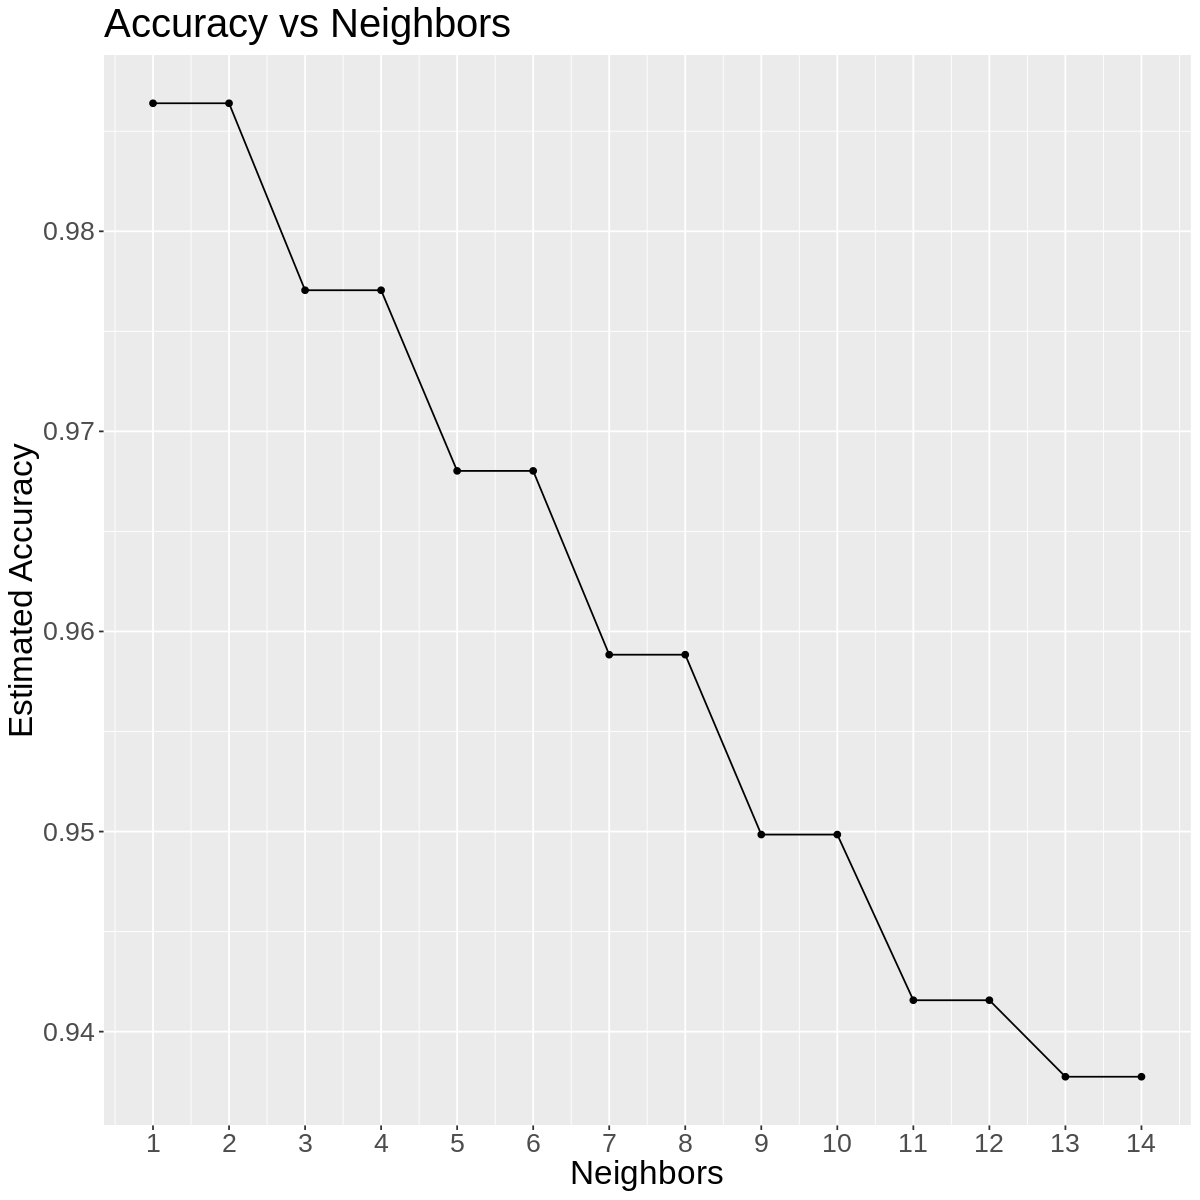

In [32]:
acc_maximum <- ggplot(pulsar_result, aes(x = neighbors, y = mean)) +
               geom_point() +
               geom_line() +
               ggtitle("Accuracy vs Neighbors") +
               labs(x = "Neighbors", y = "Estimated Accuracy") +
               scale_x_continuous(breaks = seq(0, 14, 1)) +
               theme(text = element_text(size = 20))
acc_maximum

> **Figure 4:** *The figure depicts the relationship between the estimated accuracy and the number of neighbors used in the analysis. It can be observed that as the number of neighbors increases, the estimated accuracy decreases.*

#### Calculating Model Accuracy and Confusion Matrix:

In [24]:
knn_best <- maximum |>
            pull(neighbors)

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = knn_best) |>
            set_engine("kknn") |>
            set_mode("classification")

pulsar_fit <- workflow() |>
              add_recipe(pulsar_recipe) |>
              add_model(knn_spec) |>
              fit(data = pulsar_train)

pulsar_predictions <- pulsar_fit |>
                      predict(pulsar_test) |>
                      bind_cols(pulsar_test) |>
                      metrics(truth = class, estimate = .pred_class) |>
                      filter(.metric == "accuracy")
pulsar_predictions

pulsar_matrix <- pulsar_fit |>
                 predict(pulsar_test) |>
                 bind_cols(pulsar_test) |>
                 conf_mat(truth = class, estimate = .pred_class)
pulsar_matrix

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9892368


          Truth
Prediction    0    1
         0 3502    2
         1   75 3575

_Table 7: Accuracy and Confusion Matrix_

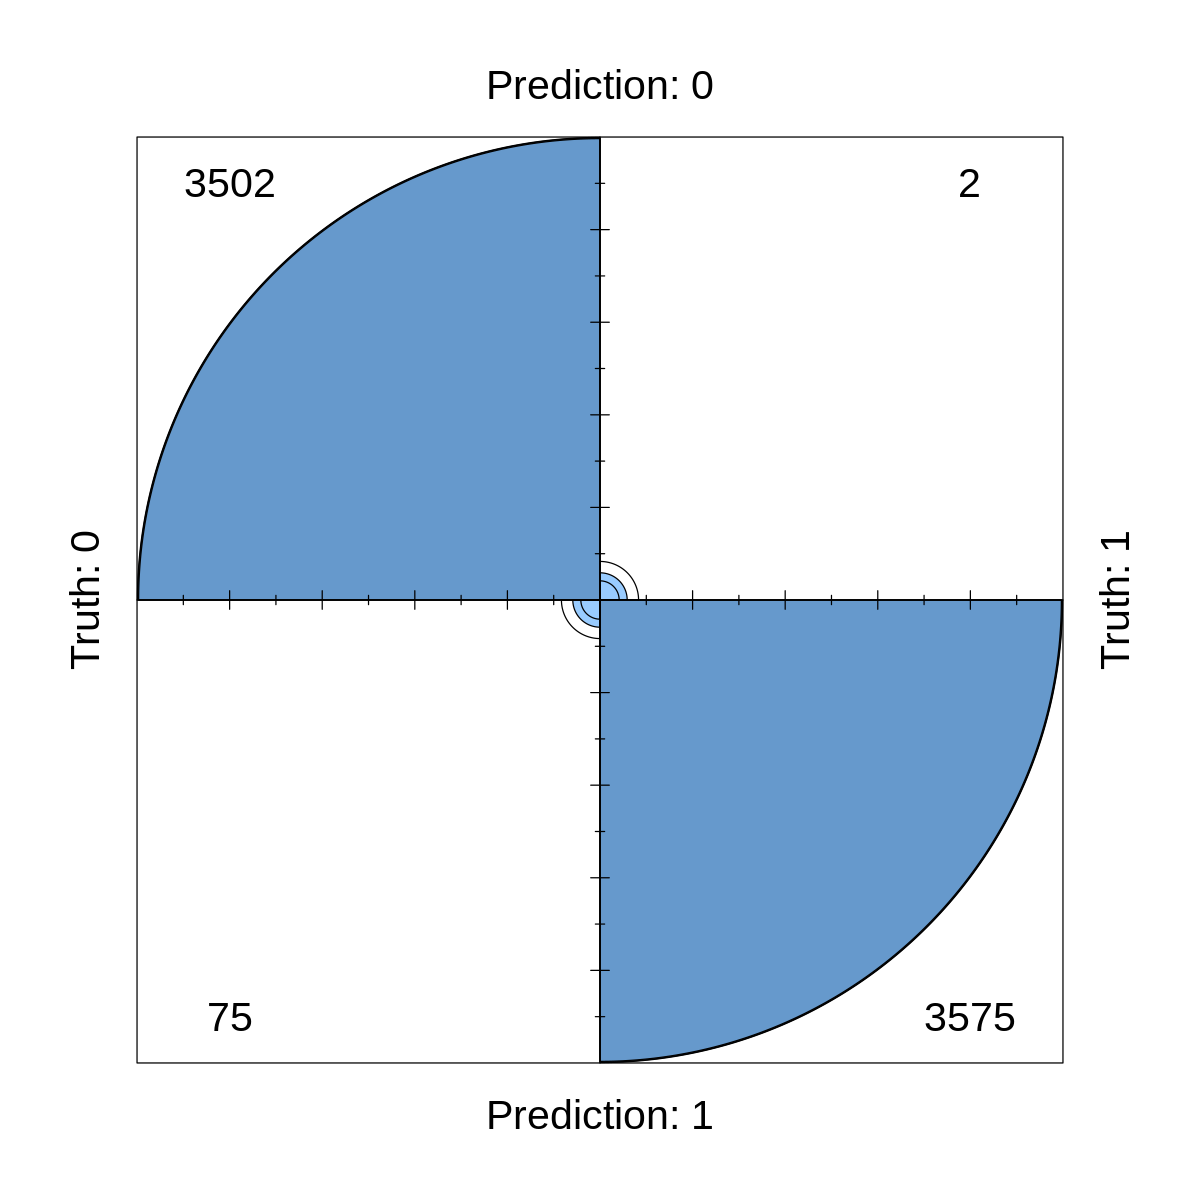

In [25]:
fourfoldplot(pulsar_matrix$table)

> **Figure 5:** *The figure displays the results of the prediction process, indicating that 3502 predictions were accurately classified as non-pulsar, while 3575 were accurately classified as pulsar. However, there were 75 instances where the predictions were wrongly classified as pulsar when they were actually not, and only 2 instances where the predictions were wrongly classified as non-pulsar when they were actually pulsar.*

# Expected outcomes and significance

The expected outcome of this study is to develop an effective K-means clustering algorithm that can accurately identify whether a star is a pulsar or not based on the integrated profile data points. In addition to the potential practical applications of the developed K-means clustering algorithm in astrophysics research, there are several other significances that this study may have such as:

- This study may contribute to the advancement in the field of machine learning by demonstrating the effectiveness of clustering algorithms in classification tasks. The proposed methodology may serve as a valuable reference for future studies involving clustering algorithms and feature selection.

- This study may lead to a better understanding of the properties and characteristics of pulsars by identifying the most relevant features that are indicative of a pulsar. We may gain insights into the underlying physics that governs the emission of electromagnetic radiation by these celestial objects.

- This study may contribute to the ongoing efforts to search for extraterrestrial life. Pulsars have been suggested as potential candidates for hosting habitable planets, and accurate identification of pulsars could facilitate the search for extraterrestrial life by providing better understanding of the environments surrounding these objects.

# References


WANG, Y., ZHENG, W., ZHANG, S., GE, M., &amp; JIANG, K. (2023, March 8). Review of X-ray pulsar spacecraft autonomous navigation. Chinese Journal of Aeronautics. Retrieved April 13, 2023, from https://www.sciencedirect.com/science/article/pii/S1000936123000584 

Dawson, J. R., Hobbs, G., Gao, Y., Camtepe, S., Feng, Y., &amp; Tranfa, L. (2022, January 31). Physical publicly verifiable randomness from pulsars. Astronomy and Computing. Retrieved April 13, 2023, from https://www.sciencedirect.com/science/article/pii/S2213133722000038 

Buda, M., Zhu, W. W., Wang, Y. C., Lorimer, D. R., Armstrong, J. W., Lattimer, J. M., Antoniadis, J., Taylor, J. H., Bates, S. D., Lyon, R. J., Hobbs, G., Eatough, R. P., Smits, R., Nan, R. D., An, T., Stokes, G. H., &amp; Johnston, S. (2021). Research on pulsar candidate identification method based on deep residual neural network. Chinese Astronomy and Astrophysics. Retrieved April 13, 2023, from https://www.sciencedirect.com/science/article/pii/S0275106221000540 

Image: https://www.scientificamerican.com/article/the-pulsar-chart-that-became-a-pop-icon-turns-50-joy-division-rsquo-s-unknown-pleasures/
GIF: https://www.nasa.gov/feature/goddard/2017/nasa-continues-to-study-pulsars-50-years-after-their-chance-discovery